### Workbook of tonal harmony
#### Analysis of the chorale BWV66.6 from the JS Bach's corpus in music21

In [1]:
from pcsPy import *
import pickle, copy
from IPython.display import Image 

<IPython.core.display.Javascript object>

Here we import the tonal model we are going to use for the analysis. A tonal model is the matrix of all the operators that connect the chords of a chord library as roman numerals.
Typical models are built using combinations of basic chord symbols and possible extension. 

Use tonalHarmonyModel.py to generate or modify models

In [2]:
f = open('tonal.harmony.minimal','rb')
head = pickle.load(f)
table = pickle.load(f)
f.close()
tab = np.array(table)

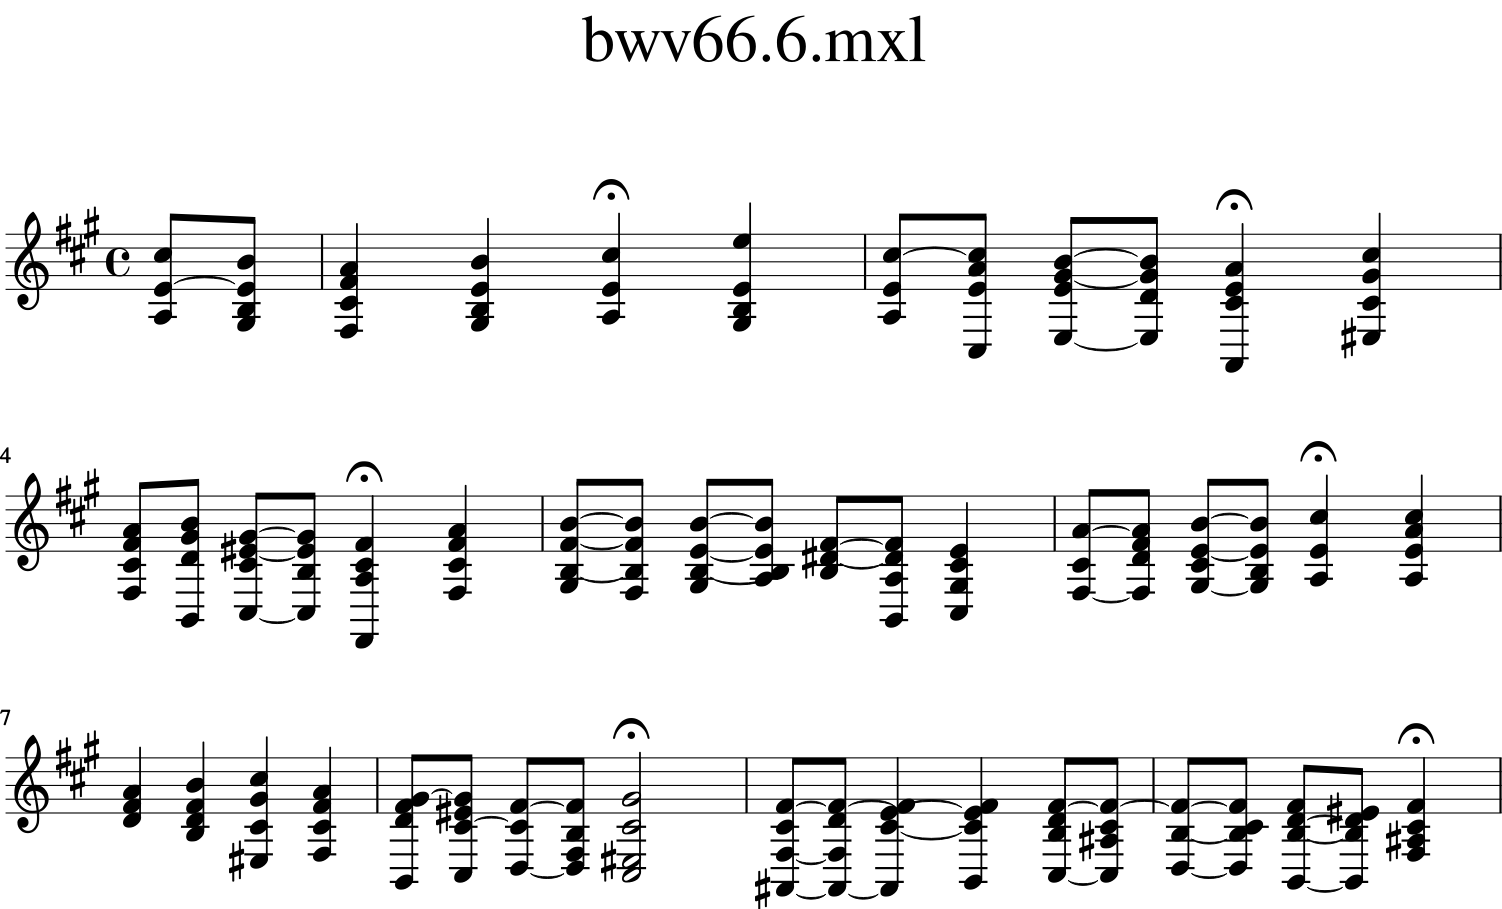

In [3]:
bachChorale = m21.corpus.parse('bwv66.6').corpusFilepath
seq,chords = readScore(bachChorale,music21=True,show=True)

In [ ]:
# To write chords and corresponding operators - uses musescore
WRITEscoreOps(seq,w=True)

In [4]:
dnodes,dedges,dcounts,deg,modul,Gx,Gxu = scoreNetwork(seq,ntx=True,general=True)
print('average degree = ',deg,' modularity = ',modul)
# Write to csv for visualization in Gephi or other network drawing software (see figure below)
# dnodes.to_csv('nodesbwv66.csv')
# dedges.to_csv('edgesbwv66.csv')
# Get modularity scores
part = cm.best_partition(Gxu)

average degree =  1.7083333333333333  modularity =  0.45844875346260383


## ![title](bwv66.png)

In [5]:
dn = np.array(dnodes)
labe = []
modu = []
modul = []
for m in range(len(dn)):
    labe.append(str(dn[m][0]))
    modu.append(part[str(m)])
    modul.append([str(dn[m][0]),Gx.degree()[str(m)],part[str(m)]])
modul = pd.DataFrame(modul,columns=['Label','Degree','Modularity'])
moduldict = dict(zip(labe,modu))

In [6]:
modul[['Label','Degree','Modularity']].query('Modularity == 0').sort_values(by=['Degree'],ascending=False)

,Label,Degree,Modularity
14,EG#B,8,0
1,AC#E,5,0
11,DF#A,4,0
17,F#B,2,0
18,F#G#B,2,0
21,G#BC#E,2,0
23,G#BDE,2,0


In [7]:
# Dictionary of modularity classes and relative keys
keydict = {0:'A', 1:'F#', 2:'A', 3:'B'}

In [8]:
# Determination of operators
try:
    ntot = seq.shape[0]
except:
    ntot = len(seq)
ops = []
for i in range(ntot):
    if i < ntot-1: 
        ops.append(generalizedOpsName(seq[i],seq[i+1])[1])

In [9]:
# Score analysis
# First chord
rn = []
ch = np.copy(seq[0])
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
n = m21.chord.Chord(ch.tolist())
chord = ''.join(n.pitchNames)
key = keydict[moduldict[chord]] 
rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
# Full score
nx = ntot-1
i = 0
while i < nx:   
    try:
        idx,idy = np.where(tab == ops[i])
        tmp = []
        for n in range(len(idy)):
            if (rn[i] == str(head[idx[n]])):
                tmp.append(head[idy[n]])
        if len(tmp) == 1:
            rn.append(tmp[0])
        else:
            chord = ''.join(m21.chord.Chord(PCSet(seq[i]).normalOrder().tolist()).pitchNames)
            key = keydict[moduldict[chord]]
            for n in range(len(tmp)):
                ch = m21.roman.RomanNumeral(tmp[n],m21.key.Key(key)).pitchClasses
                if PCSet(ch).normalOrder().tolist() == seq[i+1]:
                    rn.append(str(tmp[n]))
                    break
        i += 1
    except:
        try:
            print('possible modulation at or before chord no. ',i)
            rn.pop()
            ch = np.copy(PCSet(seq[i-1]).normalOrder().tolist())
            for n in range(1,len(ch)):
                if ch[n] < ch[n-1]: ch[n] += 12
            ch += 60
            n = m21.chord.Chord(ch.tolist())
            chord = ''.join(n.pitchNames)
            key = keydict[moduldict[chord]] 
            rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
            i -= 1
        except:
            print('PROBLEM')
            break

possible modulation at or before chord no.  35
possible modulation at or before chord no.  41


In [10]:
# Create dictionary of score analysis
reference = []
for n in range(nx):
    chord = ''.join(m21.chord.Chord(PCSet(seq[n]).normalOrder().tolist()).pitchNames)
    entry = [PCSet(seq[n]).normalOrder(),chord,rn[n],ops[n],keydict[moduldict[chord]]]
    reference.append(entry)

In [11]:
# Add last chord
ops.append(' ')
chord = ''.join(m21.chord.Chord(PCSet(seq[nx]).normalOrder().tolist()).pitchNames)
entry = [PCSet(seq[nx]).normalOrder(),chord,rn[nx],ops[nx],keydict[moduldict[chord]]]
reference.append(entry)

In [12]:
# Set dictionary as pandas dataframe
analysis = pd.DataFrame(reference,columns=['pcs','chord','rn','ops','key'])

In [13]:
analysis

,pcs,chord,rn,ops,key
0,"[9, 1, 4]",AC#E,I,"O(-1,-2,0)",A
1,"[4, 8, 11]",EG#B,V,"O(2,1,2)",A
2,"[6, 9, 1]",F#AC#,vi,"O(-2,-1,-2)",F#
3,"[4, 8, 11]",EG#B,V,"O(0,1,2)",A
4,"[9, 1, 4]",AC#E,I,"O(-1,-2,0)",A
5,"[4, 8, 11]",EG#B,V,"O(0,1,2)",A
6,"[9, 1, 4]",AC#E,I,"O(0,0,0)",A
7,"[9, 1, 4]",AC#E,I,"O(-1,-2,0)",A
8,"[4, 8, 11]",EG#B,V,"O(0,0,0,-2)",A
9,"[8, 11, 2, 4]",G#BDE,V7,"O(1,-2,-1,0)",A


In [14]:
# display the analyzed score
l = 0
analyzed = copy.deepcopy(chords)
for c in analyzed.recurse().getElementsByClass('Chord'):
    c.addLyric('')
    c.addLyric('')
    c.addLyric(str(ops[l]))
    c.addLyric(str(rn[l]))
    l += 1
analyzed.show('musicxml')